## RTI Center for Data Science - Exercise 1

*In part1, I took the brute force approach by not caring about the number of predictors or the redundancy (correlations) between them, and throwing a ton of different classification models at the data. Here, I'm going to try to take a more refined approach with some feature engineering to reduce my number of predictors.*

Links to the full instructions and SQLite database can be found [here](https://github.com/rtidatascience/data-scientist-exercise01).

Briefly, the goal is to take some census data and use it to predict the probability that a person makes more or less than $50,000/year.

First, I'll import some of our go-to libraries, as well as *sqlite3*, which I'll use to connect to our SQLite database. I'll import other libraries later as we need them.

The goal here is to "flatten" the database into a single table using various IDs to pull relevant textual information from various supporting tables. There are many ways to do this, but I'm going to leverage pandas' *read_sql_query* function, which helpfully takes a SQL query and outputs it into Python as a DataFrame. I'm going to retain everything in our _records_ table (_SELECT r.*_), and just take the textual information from all of our other tables.

Then, I'll look at the correlation structure (which will ignore the text inputs). I'll pay special attention to which variables are correlated with the target variables, *over_50k*.

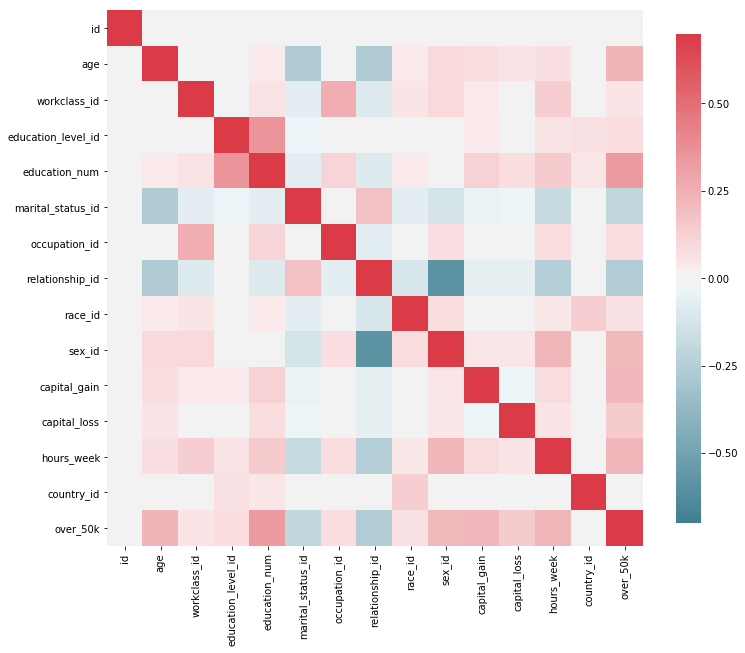

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect('./exercise01.sqlite')
records = pd.read_sql_query("""SELECT r.*, w.name AS workclass, e.name AS education_level, 
                        m.name AS marital_status, o.name AS occupation, re.name AS relationship, 
                        ra.name AS race, s.name AS sex, c.name AS country                   
    FROM records AS r
    INNER JOIN workclasses AS w ON r.workclass_id=w.id
    INNER JOIN education_levels AS e ON r.education_level_id=e.id
    INNER JOIN marital_statuses AS m ON r.marital_status_id=m.id
    INNER JOIN occupations AS o ON r.occupation_id=o.id
    INNER JOIN relationships AS re ON r.relationship_id=re.id
    INNER JOIN races AS ra ON r.race_id=ra.id
    INNER JOIN sexes AS s ON r.sex_id=s.id
    INNER JOIN countries AS c ON r.country_id=c.id
    """, conn)

conn.close()

corr = records.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr,
    vmin = -0.7, vmax = 0.7,
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax
)

### Using theory and data to select variables
There are some variables that I can immediately decide whether to include or exclude from the dataset. For instance, any correlations between *id* and our target variable are spurious, since I don't want the order of data entry to matter. On the other hand, I would be highly surprised if variables like *age*, *race_id*, *sex_id*, and *hours_week* were not important for accurate prediction. In general, categorical variables are more of a hassle to keep, because they need to be dummy-coded (which can increase the number of predictors by a large number), so let's also look at the number of options within each categorical variable.

| Keep | Drop | TBD |
|---|---|---|
|age|id|workclass_id|
|race_id||education_level_id|
|sex_id||education_num|
|hours_week||marital_status_id|
|||occupation_id|
|||relationship_id|
|||capital_gain|
|||capital_loss|
|||country_id|


In [2]:
# determine number of unique categories for each categorical variable
def find_ids(str):
    val = str.find('_id') != -1
    return val

def n_unique(series):
    return len(np.unique(series))

cat_records = records.loc[:,list(map(find_ids, list(records.columns)))]
cat_records.apply(n_unique)

workclass_id           9
education_level_id    16
marital_status_id      7
occupation_id         15
relationship_id        6
race_id                5
sex_id                 2
country_id            42
dtype: int64

*sex_id* only has 2 options, so instead of dummy-coding it, we can just use the numbers in the ID column. Let's look at how our target variable, *over_50k*, varies across the different options within each of these categorical predictors so we can decide if any options can be combined, or variables can be discarded.

In [3]:
cat_records_named = records.select_dtypes(include=['object'])

for n in cat_records_named:
    print(records.groupby([n]).mean()['over_50k'])

workclass
?                   0.094677
Federal-gov         0.391760
Local-gov           0.295599
Never-worked        0.000000
Private             0.217867
Self-emp-inc        0.553392
Self-emp-not-inc    0.278871
State-gov           0.267542
Without-pay         0.095238
Name: over_50k, dtype: float64
education_level
10th            0.062635
11th            0.050773
12th            0.073059
1st-4th         0.032389
5th-6th         0.053045
7th-8th         0.064921
9th             0.054233
Assoc-acdm      0.257964
Assoc-voc       0.253275
Bachelors       0.412835
Doctorate       0.725589
HS-grad         0.158578
Masters         0.549116
Preschool       0.012048
Prof-school     0.739808
Some-college    0.189649
Name: over_50k, dtype: float64
marital_status
Divorced                 0.101161
Married-AF-spouse        0.378378
Married-civ-spouse       0.446133
Married-spouse-absent    0.092357
Never-married            0.045480
Separated                0.064706
Widowed                  0.08432

In [4]:
# start building new dataset
data = pd.DataFrame()
data['over_50k'] = records.over_50k
data['age'] = records.age
data['sex'] = records.sex_id # keep as numerical because there are only two options
data['hours_week'] = records.hours_week

# we can simplify race by grouping white/asian
white = records.race=='White'
asian = records.race=='Asian-Pac-Islander'
data['race'] = np.bitwise_or(white,asian).astype(int)

# we can also simplify marital status by grouping Married-AF-spouse and Married-civ-spouse
AF = records.marital_status=='Married-AF-spouse'
civ = records.marital_status=='Married-civ-spouse'
data['marital_status'] = np.bitwise_or(AF,civ).astype(int)

# add in capital gains and losses
data['capital_gain'] = records.capital_gain
data['capital_loss'] = records.capital_loss


I've added marital status to the 'Keep' list, and started building a new DataFrame based on the features that we want. I've also added capital gains and losses, because they are numeric variables and therefore are low-cost (in terms of interpretability).

| Keep | Drop | TBD |
|---|---|---|
|age|id|workclass_id|
|race_id||education_level_id|
|sex_id||education_num|
|hours_week||country_id|
|marital_status_id||occupation_id|
|capital_gain||relationship_id|
|capital_loss|||

In [5]:
# let's start to look at education (which is likely to be an important predictor) and see how we can simplify it
print(records.groupby(['education_num']).mean()['over_50k'].sort_values())

education_num
1     0.012048
2     0.032389
7     0.050773
3     0.053045
5     0.054233
6     0.062635
4     0.064921
8     0.073059
9     0.158578
10    0.189649
11    0.253275
12    0.257964
13    0.412835
14    0.549116
16    0.725589
15    0.739808
Name: over_50k, dtype: float64


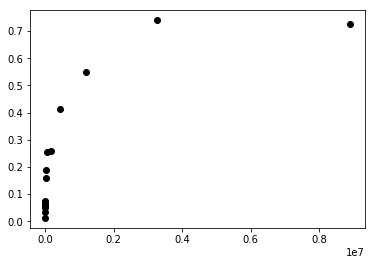

In [6]:
# over_50k seems to more or less increase exponentially as a function of education_num
# maybe we can exponentiate education_num (making the relationship with over_50k linear)
mean_target = records.groupby(['education_num']).mean()['over_50k']
plt.plot(np.exp(mean_target.index), mean_target,'ko')


Exponentiating seems too much, but I'm sure there is some other number we can find. Mathematically, I want to fit some curve $y = \alpha \beta^x$, where $y$ is our target, $x$ is our predictor, and $\alpha$ and $\beta$ are constants to determine. By taking the log of both sides, I get:

\begin{equation}
\log(y) = x \log(\beta) + \log(\alpha)
\end{equation}

[1.27861969]


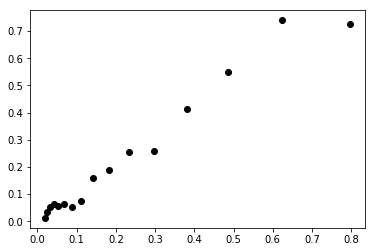

In [7]:
# that's not quite right, let's try a different power
ln_y = np.log(mean_target)
x = np.asarray(mean_target.index.tolist())

from sklearn.linear_model import LinearRegression
mdl = LinearRegression()
mdl.fit(x.reshape(-1,1),ln_y)
print(np.exp(mdl.coef_))

x_trans = np.exp(mdl.intercept_)*np.exp(mdl.coef_)**x.reshape(-1,1)

plt.plot(x_trans, mean_target, 'ko')


This looks great! I just want to recode *education_num* to combine groups 15 and 16 (the two rightmost data points, corresponding to people with doctorates and people who went to professional school) before using my transform.

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


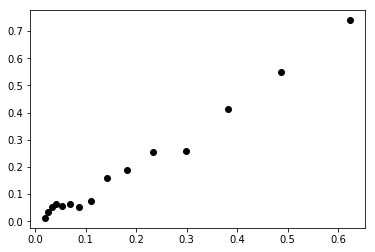

In [8]:
education_num = records.education_num
education_num.loc[education_num==16] = 15
data['education_num'] = np.exp(mdl.intercept_)*np.exp(mdl.coef_)**education_num

# check that transformation worked
ed_nums = data['education_num'].unique()
ed_nums.sort()
plt.plot(ed_nums, mean_target[0:-1], 'ko')

Great! Now I've added education_num to my new DataFrame, and I can drop education_level_id because it carries redundant information.

| Keep | Drop | TBD |
|---|---|---|
|age|id|workclass_id|
|race_id|education_level_id|relationship_id|
|sex_id||occupation_id|
|hours_week||country_id|
|marital_status_id|||
|capital_gain|||
|capital_loss|||
|education_num|||

All of my remaining predictors can't easily be converted into a numerical representation (like education level was) and can't easily be consolidated into fewer categorical levels (like race was). So, before I go down that rabbit hole, I'm going to take some time and built a model to see how good prediction is with just these variables.

In [11]:
from sklearn.model_selection import train_test_split

test = data['over_50k']
train = data.drop(['over_50k'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(train, test, train_size=0.7)

/Users/zacharyabzug/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

mdl = DecisionTreeClassifier()

# use GridSearchCV to search for some tree parameters
# max_depth: 5,8,10,15,20,None
# min_samples_leaf: 1,2,3,5,10

param_grid = {'max_depth':[5,8,10,15,20,None],
             'min_samples_leaf':[1,2,3,5,10]}

grid_search = GridSearchCV(mdl, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(train_X,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 8, 10, 15, 20, None], 'min_samples_leaf': [1, 2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [20]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.85907748106116
{'max_depth': 8, 'min_samples_leaf': 3}


In [22]:
mdl = DecisionTreeClassifier(max_depth=8,min_samples_leaf=3)
mdl.fit(train_X,train_y)
train_acc = mdl.score(train_X, train_y)
test_acc = mdl.score(test_X, test_y)

print(train_acc, test_acc)

0.8615929100002925 0.8521121954548556
